In [1]:
import os
import json
import torch as tc
from numpy import exp
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

from gpt_2_gen.model import CausalLM
from gpt_2_gen.utils import to_device, get_device, set_seed, generate_namespace
from gpt_2_gen.plots import plot_perplexity

os.environ["TOKENIZERS_PARALLELISM"] = "false"

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
cfg = generate_namespace(path=f"../config.yaml")
print(json.dumps(vars(cfg), indent=2))

set_seed(cfg.seed)
device = get_device()

{
  "model_name": "gpt2",
  "dataset": "imdb",
  "seed": 42,
  "dpi": 400,
  "max_token_length": 128,
  "train_size": 3000,
  "val_size": 500,
  "lr": 2e-05,
  "warmup_ratio": 0.1,
  "epochs": 3,
  "train_batch_size": 4,
  "eval_batch_size": 4,
  "strategy": "epoch",
  "fig_path": "../outputs/",
  "res_path": "../results/"
}


In [3]:
dataset = load_dataset(cfg.dataset)

inst = CausalLM(cfg.model_name)
dataset = inst.clean_data(dataset)
data_tokenized = inst.tokenize_dataset(dataset, cfg.max_token_length)
data_collator = inst.data_collator()
print(data_tokenized)

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20676 [00:00<?, ? examples/s]

Map:   0%|          | 0/20904 [00:00<?, ? examples/s]

Map:   0%|          | 0/41349 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 20676
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 20904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 41349
    })
})


In [5]:
model = inst.load_model()

training_args = TrainingArguments(
    output_dir=cfg.res_path,
    overwrite_output_dir=True,
    report_to="none",
    eval_strategy=cfg.strategy,
    save_strategy=cfg.strategy,
    logging_strategy= cfg.strategy,
    learning_rate=cfg.lr,
    per_device_train_batch_size=cfg.train_batch_size,
    per_device_eval_batch_size=cfg.eval_batch_size,
    num_train_epochs=cfg.epochs,
    warmup_ratio=cfg.warmup_ratio,
    seed=cfg.seed
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_tokenized["train"].shuffle(seed=cfg.seed).select(range(cfg.train_size)),
    eval_dataset=data_tokenized["test"].shuffle(seed=cfg.seed).select(range(cfg.val_size)),
    data_collator=data_collator
)

trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,3.775100,3.615644
2,3.583300,3.610687
3,3.504500,3.613800


TrainOutput(global_step=2250, training_loss=3.620974609375, metrics={'train_runtime': 1758.8743, 'train_samples_per_second': 5.117, 'train_steps_per_second': 1.279, 'total_flos': 587907072000000.0, 'train_loss': 3.620974609375, 'epoch': 3.0})

In [6]:
eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = exp(eval_loss)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 37.11


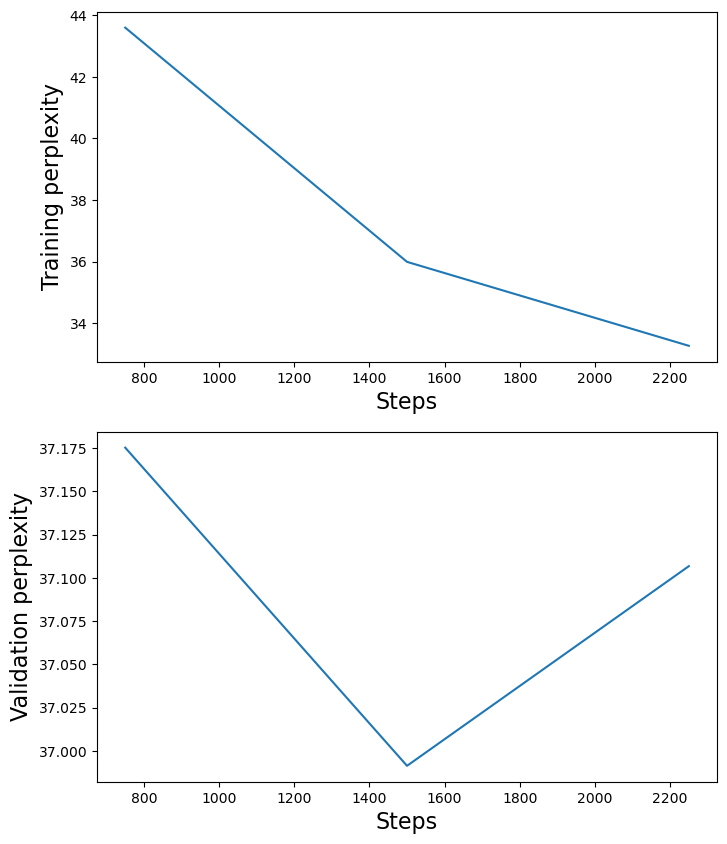

In [7]:
plot_perplexity(trainer.state.log_history, cfg.fig_path, cfg.dpi)

In [10]:
reviews = [
    "This movie was terrible. The acting was mediocre.",
    "I highly recommend this movie to everyone.",
    "This was a great movie. I wish it was longer.",
    "I do not recommend this movie. The actors are terrible.",
]

inputs = inst.tokenize_text(reviews)
outputs = inst.evaluate_model(inputs, model)

for i, seq in enumerate(outputs):
    print(f"Seq. {i + 1}:")
    print(f"{inst.tokenizer.decode(seq, skip_special_tokens=True)}")
    print("\n")

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Seq. 1:
This movie was terrible. The acting was mediocre.A lot of the scenes were lame and poorly done.<br /><p>I have watched this film several times over but


Seq. 2:
I highly recommend this movie to everyone.
Posted by: Jim Henson at 1/8th of September, 2008 11 comments This is a great film with some


Seq. 3:
This was a great movie. I wish it was longer. It is not, and that's why there are so many people who have been disappointed in this film.<br /><p


Seq. 4:
I do not recommend this movie. The actors are terrible. I saw it for the first time and thought they were great! However, once you see what happens when a group of people




In [11]:
reviews = [
    "Wow! I was suprised by how much ",
    "This film was such a surprise. ",
    "I never thought I would ",
    "This movie makes me want to yell "
]

inputs = inst.tokenize_text(reviews)
outputs = inst.evaluate_model(inputs, model)

for i, seq in enumerate(outputs):
    print(f"Seq. {i + 1}:")
    print(f"{inst.tokenizer.decode(seq, skip_special_tokens=True)}")
    print("\n")

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Seq. 1:
Wow! I was suprised by how much iced the movie.<br /><br />The plot is so bad, there isn't even a single scene. All characters


Seq. 2:
This film was such a surprise. The acting is amazing, the direction and plot are just so unique! I am extremely proud to have seen this movie.<br


Seq. 3:
I never thought I would Theatre be so bad. The plot is not even close to the original script, but it works perfectly on this film.<


Seq. 4:
This movie makes me want to yell "I can't believe this is so much of a bad film!" I have never seen anything like it and the acting has


